# Data Setup

In [2]:
!ls

README.md                     requirements.txt
data                          ts-hf-periodic-refactor.ipynb
environment.yaml              weights
examine_and_clean_macho.ipynb


In [1]:
import os
print(os.environ.get('CONDA_DEFAULT_ENV'))
os.environ.update({"PYTORCH_ENABLE_MPS_FALLBACK": "1"})

multi_modal


In [2]:
import joblib
import os
import numpy as np
import torch
from evaluate import load
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import PretrainedConfig
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(f"{torch.__version__=}")
print(f"{transformers.__version__=}")

torch.__version__='2.1.0'
transformers.__version__='4.35.0'


In [3]:
class MachoDataset(Dataset):
    def __init__(self, data_root, prediction_length, mode='train', use_errors=True):
        data = joblib.load(data_root + f'{mode}.pkl')
        self.data = data
        self.prediction_length = prediction_length
        self.use_errors = use_errors
        
        if use_errors and data[0][:, :, :].shape[1] != 3:
            raise Exception("use_errors was True but dataset does not contain errors."
                            " Try running preprocess_data.py with the flag --use-error")

        self.times = data[0][:, 0, :]
        if use_errors:
            self.values = data[0][:, 1:, :]
        else:
            self.values = data[0][:, 1, :]
        
        self.aux = data[1]
        self.labels = data[2]
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        past_times = torch.tensor(self.times[idx, :-self.prediction_length], dtype=torch.float)
        future_times = torch.tensor(self.times[idx, -self.prediction_length:], dtype=torch.float)
        if use_errors:
            past_values = torch.tensor(self.values[idx, :, :-self.prediction_length], dtype=torch.float).T
            future_values = torch.tensor(self.values[idx, :, -self.prediction_length:], dtype=torch.float).T       
        else:
            past_values = torch.tensor(self.values[idx, :-self.prediction_length], dtype=torch.float)
            future_values = torch.tensor(self.values[idx, -self.prediction_length:], dtype=torch.float)       
        
        past_mask = torch.ones(past_times.shape, dtype=torch.float)
        future_mask = torch.ones(future_times.shape, dtype=torch.float)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)

        past_times = past_times.unsqueeze(-1)
        future_times = future_times.unsqueeze(-1)

        return past_times, future_times, past_values, future_values, past_mask, future_mask, labels

In [4]:
data_root = './data/data/macho/'
window_length = 200
prediction_length = 1

In [5]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"device: {device}")

device: mps


In [6]:
data = joblib.load(data_root + f'train.pkl')

In [7]:
use_errors = True
train_dataset = MachoDataset(data_root, prediction_length, mode='train', use_errors=use_errors)
val_dataset = MachoDataset(data_root, prediction_length, mode='val', use_errors=use_errors)
test_dataset = MachoDataset(data_root, prediction_length, mode='test', use_errors=use_errors)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [9]:
past_times, future_times, past_values, future_values, past_mask, future_mask, labels = train_dataset[10]

In [10]:
# (torch.Size([197, 1]), torch.Size([197]), torch.Size([3]))
past_times.shape, past_values.shape, future_values.shape

(torch.Size([199, 1]), torch.Size([199, 2]), torch.Size([1, 2]))

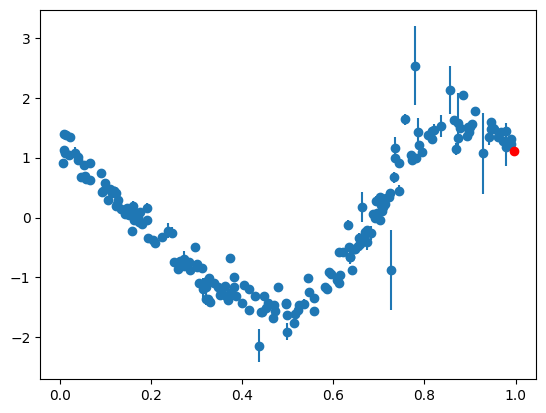

In [11]:
if use_errors:
    plt.errorbar(past_times, past_values[:,0], past_values[:,1], fmt="o")
    plt.errorbar(future_times, future_values[:,0], future_values[:,1], fmt="o", c="r")
else:
    plt.scatter(past_times, past_values, c="b")
    plt.scatter(future_times, future_values, c="r")  


# Time Series Prediction Model Setup

In [12]:
def train_step(train_dataloader, model, optimizer):
    total_loss = []
    
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        past_times, future_times, past_values, future_values, past_mask, future_mask, _ = batch
        
        outputs = model(
            past_time_features=past_times.to(device),
            past_values=past_values.to(device),
            future_time_features=future_times.to(device),
            future_values=future_values.to(device),
            past_observed_mask=past_mask.to(device),
            future_observed_mask=future_mask.to(device),
        )

        loss = outputs.loss
        total_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    return sum(total_loss) / len(total_loss)

In [13]:
def val_step(val_dataloader, model):
    total_loss = []

    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            past_times, future_times, past_values, future_values, past_mask, future_mask, _ = batch
            
            outputs = model(
                past_time_features=past_times.to(device),
                past_values=past_values.to(device),
                future_time_features=future_times.to(device),
                future_values=future_values.to(device),
                past_observed_mask=past_mask.to(device),
                future_observed_mask=future_mask.to(device),
            )
        
            loss = outputs.loss
            total_loss.append(loss.item())
            
    return sum(total_loss) / len(total_loss)

In [14]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=window_length - prediction_length - 7,    # 7 is max(lags) for default lags
    num_time_features=1,
    distribution_output="normal",  # student_t
    encoder_layers=2,
    decoder_layers=2,
    d_model=64,
    input_size = 1 if not use_errors else 2,
    scaling=None,  # std None mean
    loss="kl_ts_uncertainty",  # nll
)

model = TimeSeriesTransformerForPrediction(config)

In [15]:
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [16]:
train_losses, val_losses = [], []

for epoch in range(10):
    model.train()
    train_loss = train_step(train_dataloader, model, optimizer)
    train_losses.append(train_loss)

    model.eval()
    val_loss = val_step(val_dataloader, model)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch}: Train Loss {round(train_loss, 4)} Val Loss {round(val_loss, 4)}')

ZeroDivisionError: division by zero

> /Users/jbloom/miniforge3/envs/multi_modal/lib/python3.10/site-packages/transformers/models/time_series_transformer/modeling_time_series_transformer.py(228)nll()
    226     Computes the negative log likelihood loss from input distribution with respect to target.
    227     """
--> 228     1/0
    229     return -input.log_prob(target)
    230 



ipdb>  target.shape


torch.Size([256, 1, 2])


ipdb>  input.shape


*** AttributeError: 'AffineTransformed' object has no attribute 'shape'. Did you mean: 'scale'?


ipdb>  type(input)


<class 'transformers.time_series_utils.AffineTransformed'>


ipdb>  target.base_dist


*** AttributeError: 'Tensor' object has no attribute 'base_dist'


ipdb>  input


AffineTransformed()


ipdb>  input.scale


tensor([[[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1., 1.]],

        [[1.,

ipdb>  input.scale.shape


torch.Size([256, 1, 2])


ipdb>  input.loc.shape


torch.Size([256, 1, 2])


ipdb>  input.base_dist.mean


tensor([[[-2.9107e-02, -3.1163e-01]],

        [[-7.0946e-02, -3.1517e-01]],

        [[-1.1454e-02, -2.3039e-01]],

        [[-9.2772e-02, -2.9468e-01]],

        [[-6.0582e-02, -4.0841e-01]],

        [[-5.6396e-02, -3.4926e-01]],

        [[-7.9465e-02, -3.1242e-01]],

        [[-3.0322e-02, -3.8905e-01]],

        [[-7.1906e-02, -3.1198e-01]],

        [[-1.0929e-01, -2.9603e-01]],

        [[-1.0034e-01, -2.5518e-01]],

        [[-1.0328e-01, -3.4481e-01]],

        [[-1.0366e-01, -3.3636e-01]],

        [[-3.6241e-02, -2.5984e-01]],

        [[-1.0993e-01, -3.9034e-01]],

        [[-6.4016e-03, -3.6285e-01]],

        [[-1.5141e-02, -3.1918e-01]],

        [[-9.6349e-02, -3.4014e-01]],

        [[-3.9460e-02, -2.5684e-01]],

        [[-1.1226e-01, -3.0082e-01]],

        [[-3.4455e-02, -3.8172e-01]],

        [[-1.3578e-01, -2.4145e-01]],

        [[-1.1799e-01, -3.0871e-01]],

        [[-8.4032e-02, -3.4267e-01]],

        [[-7.3733e-02, -3.8466e-01]],

        [[-1.2175e-01, -2

ipdb>  input.base_dist.mean.shape


torch.Size([256, 1, 2])


ipdb>  input.variance


tensor([[[3.6163, 2.6717]],

        [[3.6116, 2.6178]],

        [[3.5128, 2.6563]],

        [[3.8969, 2.6193]],

        [[3.6535, 2.7721]],

        [[3.6907, 2.8336]],

        [[3.5243, 2.6693]],

        [[3.5437, 2.6616]],

        [[3.3923, 2.6385]],

        [[3.8385, 2.5749]],

        [[3.5279, 2.6627]],

        [[3.1669, 2.7906]],

        [[3.6051, 2.9109]],

        [[3.4655, 2.7517]],

        [[3.6914, 2.4779]],

        [[3.4224, 2.7969]],

        [[3.4244, 2.5444]],

        [[3.5805, 2.7730]],

        [[3.5923, 2.4806]],

        [[3.9390, 2.5768]],

        [[3.3923, 2.8566]],

        [[3.5022, 2.6065]],

        [[3.6398, 2.6129]],

        [[3.6902, 2.6378]],

        [[3.5482, 2.9918]],

        [[3.0330, 2.7814]],

        [[3.7307, 2.6605]],

        [[3.5034, 2.7575]],

        [[3.5982, 3.0030]],

        [[3.8263, 2.6448]],

        [[3.5599, 2.7751]],

        [[3.3526, 2.6592]],

        [[3.2262, 2.7690]],

        [[3.1777, 2.7368]],

        [[3.41

ipdb>  input.variance.shape


torch.Size([256, 1, 2])


ipdb>  input.base_dist


Independent(StudentT(df: torch.Size([256, 1, 2]), loc: torch.Size([256, 1, 2]), scale: torch.Size([256, 1, 2])), 1)


ipdb>  input.base_dist.df


*** AttributeError: 'Independent' object has no attribute 'df'


ipdb>  input.rsample()


/Users/jbloom/miniforge3/envs/multi_modal/lib/python3.10/site-packages/torch/distributions/gamma.py:12: UserWarning: The operator 'aten::_standard_gamma' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._standard_gamma(concentration)


tensor([[[ 3.6095e-01, -4.3494e-03]],

        [[ 2.0260e-01,  1.0884e-01]],

        [[-4.6401e-01, -2.7020e-01]],

        [[-7.6143e-01, -9.5355e-01]],

        [[-7.8649e-02, -6.7058e-01]],

        [[ 6.3132e-01, -1.1766e+00]],

        [[-1.9120e+00, -1.0884e+00]],

        [[-2.5539e+00,  1.1202e-01]],

        [[ 1.2694e+00, -5.8709e-01]],

        [[ 6.5056e-02,  1.0640e+01]],

        [[-7.1708e-01, -1.5661e+00]],

        [[ 8.2872e-01, -4.6947e-01]],

        [[-2.0152e+00,  3.3606e+00]],

        [[ 3.3094e-01,  1.1723e+00]],

        [[-1.4713e-01, -9.1752e-01]],

        [[ 1.7863e+00, -7.4051e-01]],

        [[ 6.6844e+00, -3.6576e-01]],

        [[ 1.0193e+00, -7.1851e-01]],

        [[ 1.3484e-01, -1.9467e+00]],

        [[-1.1017e+00,  3.4246e+00]],

        [[ 1.6617e-01,  7.6431e-01]],

        [[ 3.5350e+00, -7.8923e-01]],

        [[-4.5448e-01, -1.7938e+00]],

        [[ 6.8645e-01, -9.7927e-01]],

        [[ 8.9845e-01, -4.7588e-01]],

        [[ 1.8445e+00, -1

ipdb>  input.rsample().shape


torch.Size([256, 1, 2])


ipdb>  input.rsample()


tensor([[[ 1.3434e+00,  5.5039e-01]],

        [[ 3.5696e+00, -8.9329e-01]],

        [[ 8.8599e-01, -8.6960e-01]],

        [[-1.0517e+00,  1.8553e-01]],

        [[ 4.7122e-01, -7.5611e-02]],

        [[ 2.2833e-01, -1.3002e+00]],

        [[-3.0051e-02, -2.4934e-01]],

        [[ 2.0598e+00, -4.0262e-01]],

        [[ 1.5094e+00, -1.3142e+00]],

        [[ 3.3976e-01,  5.8677e+00]],

        [[ 1.0277e+00, -1.0651e+00]],

        [[-4.1031e-02, -8.0998e-01]],

        [[ 1.1443e+00, -8.6426e-01]],

        [[-6.0604e-01,  1.2400e+00]],

        [[ 5.9270e-01,  4.6558e-01]],

        [[ 1.0585e+00, -1.0739e+00]],

        [[ 3.9874e-01,  2.3414e+00]],

        [[-8.6925e-01,  1.0366e+00]],

        [[-1.9364e+00, -7.2524e-01]],

        [[ 7.8139e-01, -8.7578e-01]],

        [[ 1.1435e+00, -4.8371e-01]],

        [[ 9.2432e-01,  7.4936e-01]],

        [[-8.4878e-01, -1.2647e+00]],

        [[ 9.4043e-01, -1.4704e+00]],

        [[-2.4022e-01, -3.3400e-01]],

        [[-3.5507e+00, -1

ipdb>  input.rsample(sample_shape=[256,10,2])


tensor([[[[[[-9.8540e-01,  1.3596e+00]],

           [[-1.7868e+00, -2.2599e-01]],

           [[-2.2845e+00, -4.6738e-01]],

           ...,

           [[ 3.8523e+00, -1.0253e+00]],

           [[-5.0934e-01, -1.1469e+00]],

           [[ 3.1186e-03,  4.8849e-01]]],


          [[[ 2.0589e+00, -2.1198e-01]],

           [[-2.1896e+00, -1.0514e+00]],

           [[-1.0308e+00,  6.5735e-01]],

           ...,

           [[-2.7744e-01, -2.4621e-01]],

           [[ 1.7615e+00, -1.0958e+00]],

           [[ 1.6858e+00, -5.9202e-01]]]],



         [[[[-9.5450e-01,  1.0803e+00]],

           [[-2.3705e+00, -2.1939e-01]],

           [[-1.9538e+00, -4.6115e-01]],

           ...,

           [[ 6.3271e+00, -4.5936e+00]],

           [[-6.9358e-01, -9.3238e-01]],

           [[ 4.8538e-02,  2.7032e+00]]],


          [[[ 1.4315e+00, -1.7086e-01]],

           [[-3.5557e+00, -1.2181e+00]],

           [[-1.8953e+00,  1.3996e+00]],

           ...,

           [[-4.9508e-01, -2.4876e-01]],



ipdb>  input.rsample(sample_shape=[256,10,2]).shape


torch.Size([256, 10, 2, 256, 1, 2])


ipdb>  input.sample(sample_shape=[256,10,2]).shape


torch.Size([256, 10, 2, 256, 1, 2])


ipdb>  input.sample(sample_shape=[10]).shape


torch.Size([10, 256, 1, 2])


ipdb>  input.sample(sample_shape=[100]).shape


torch.Size([100, 256, 1, 2])


ipdb>  import matplotlib.pyplot as plt
ipdb>  a=input.sample(sample_shape=[100])


input = AffineTransformed()
target = tensor([[[ 1.1024e+00,  2.1772e+00]],

        [[ 3.1114e+00,  1.4761e-01]],

        [[ 5.1210e-01,  5.9002e-02]],

        [[ 8.3943e-01,  5.8365e-01]],

        [[ 5.3114e+00,  4.1811e-01]],

        [[-1.6225e+00,  6.3479e-01]],

        [[ 1.1662e+00,  5.2098e-01]],

        [[-1.3431e+00,  9.0591e-02]],

        [[ 1.7831e+00,  4.8382e-01]],

        [[-7.7729e-01,  6.5439e-02]],

        [[-1.8917e-01,  2.5169e-01]],

        [[ 2.7472e-01,  6.9801e-03]],

        [[ 6.9222e-01,  3.7090e-01]],

        [[-1.3887e-01,  1.0465e-01]],

        [[ 4.6390e-02,  1.2863e+00]],

        [[ 5.9043e-01,  8.5441e-02]],

        [[-1.3656e-01,  8.3530e-02]],

        [[-8.7757e-01,  3.5164e-02]],

        [[ 1.3106e+00,  7.1244e-01]],

        [[-2.5985e+00,  1.0988e+00]],

        [[-1.2188e+00,  5.1509e-01]],

        [[-1.3239e+00,  2.3816e-01]],

        [[ 1.4020e+00,  1.0593e+00]],

        [[ 2.4453e+00,  1.3241e-01]],

        [[ 2.0195e+00,  7.1

ipdb>  a


input = AffineTransformed()
target = tensor([[[ 1.1024e+00,  2.1772e+00]],

        [[ 3.1114e+00,  1.4761e-01]],

        [[ 5.1210e-01,  5.9002e-02]],

        [[ 8.3943e-01,  5.8365e-01]],

        [[ 5.3114e+00,  4.1811e-01]],

        [[-1.6225e+00,  6.3479e-01]],

        [[ 1.1662e+00,  5.2098e-01]],

        [[-1.3431e+00,  9.0591e-02]],

        [[ 1.7831e+00,  4.8382e-01]],

        [[-7.7729e-01,  6.5439e-02]],

        [[-1.8917e-01,  2.5169e-01]],

        [[ 2.7472e-01,  6.9801e-03]],

        [[ 6.9222e-01,  3.7090e-01]],

        [[-1.3887e-01,  1.0465e-01]],

        [[ 4.6390e-02,  1.2863e+00]],

        [[ 5.9043e-01,  8.5441e-02]],

        [[-1.3656e-01,  8.3530e-02]],

        [[-8.7757e-01,  3.5164e-02]],

        [[ 1.3106e+00,  7.1244e-01]],

        [[-2.5985e+00,  1.0988e+00]],

        [[-1.2188e+00,  5.1509e-01]],

        [[-1.3239e+00,  2.3816e-01]],

        [[ 1.4020e+00,  1.0593e+00]],

        [[ 2.4453e+00,  1.3241e-01]],

        [[ 2.0195e+00,  7.1

ipdb>  a.shape


input = AffineTransformed()
target = tensor([[[ 1.1024e+00,  2.1772e+00]],

        [[ 3.1114e+00,  1.4761e-01]],

        [[ 5.1210e-01,  5.9002e-02]],

        [[ 8.3943e-01,  5.8365e-01]],

        [[ 5.3114e+00,  4.1811e-01]],

        [[-1.6225e+00,  6.3479e-01]],

        [[ 1.1662e+00,  5.2098e-01]],

        [[-1.3431e+00,  9.0591e-02]],

        [[ 1.7831e+00,  4.8382e-01]],

        [[-7.7729e-01,  6.5439e-02]],

        [[-1.8917e-01,  2.5169e-01]],

        [[ 2.7472e-01,  6.9801e-03]],

        [[ 6.9222e-01,  3.7090e-01]],

        [[-1.3887e-01,  1.0465e-01]],

        [[ 4.6390e-02,  1.2863e+00]],

        [[ 5.9043e-01,  8.5441e-02]],

        [[-1.3656e-01,  8.3530e-02]],

        [[-8.7757e-01,  3.5164e-02]],

        [[ 1.3106e+00,  7.1244e-01]],

        [[-2.5985e+00,  1.0988e+00]],

        [[-1.2188e+00,  5.1509e-01]],

        [[-1.3239e+00,  2.3816e-01]],

        [[ 1.4020e+00,  1.0593e+00]],

        [[ 2.4453e+00,  1.3241e-01]],

        [[ 2.0195e+00,  7.1

ipdb>  plt.hist(a[:,0,0,0])


*** NameError: name 'a' is not defined


ipdb>  input.sample(sample_shape=[100]).shape


torch.Size([100, 256, 1, 2])


ipdb>  plt.hist(input.sample(sample_shape=[100])[:,0,0,0])


*** TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


ipdb>  plt.hist(input.sample(sample_shape=[100])[:,0,0,0].cpu())


(array([ 1.,  1.,  2.,  3., 15., 25., 28., 17.,  6.,  2.]), array([-6.48046589, -5.47704315, -4.47361994, -3.4701972 , -2.46677446,
       -1.46335149, -0.4599286 ,  0.54349428,  1.5469172 ,  2.55033994,
        3.55376291]), <BarContainer object of 10 artists>)


ipdb>  q


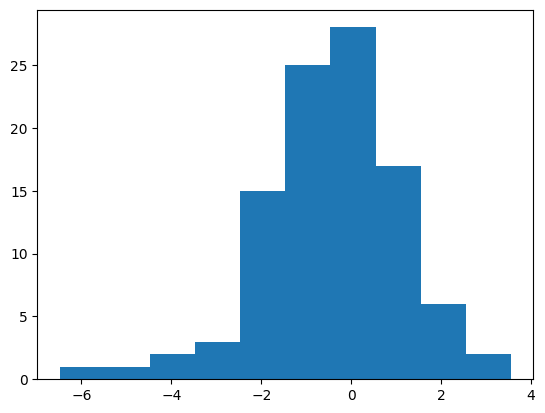

In [17]:
%debug

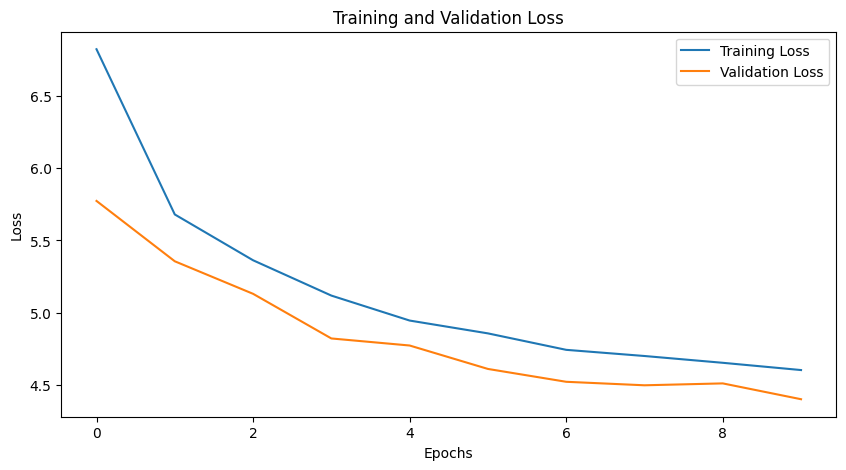

In [17]:
epochs = range(10)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
model.save_pretrained('weights/model.ckpt')

# Time Series Prediction Model Evaluation

In [19]:
def get_forecasts(model, val_dataloader):
    forecasts = []

    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            past_times, future_times, past_values, future_values, past_mask, future_mask, label = batch
            
            outputs = model.generate(
                past_time_features=past_times.to(device),
                past_values=past_values.to(device),
                future_time_features=future_times.to(device),
                past_observed_mask=past_mask.to(device),
            )
            
            forecasts.append(outputs.sequences.cpu().numpy())
    
    forecasts = np.vstack(forecasts)
    forecast_median = np.median(forecasts, 1)

    return forecast_median

In [20]:
def get_metrics(val_dataset, forecasts):
    mase_metric = load('evaluate-metric/mase')
    smape_metric = load('evaluate-metric/smape')
    
    mase_metrics = []
    smape_metrics = []
    
    for i, ts in enumerate(tqdm(val_dataset)):
        _, _, past_values, future_values, _, _, _ = val_dataset[i]
    
        mase = mase_metric.compute(
            predictions=forecasts[i],
            references=np.array(future_values),
            training=np.array(past_values)
        )
        mase_metrics.append(mase['mase'])
    
        smape = smape_metric.compute(
            predictions=forecasts[i],
            references=np.array(future_values),
        )
        smape_metrics.append(smape['smape'])

    return np.mean(mase_metrics), np.mean(smape_metrics)

In [21]:
model = TimeSeriesTransformerForPrediction.from_pretrained('weights/model.ckpt')
model = model.to(device)

In [22]:
model.eval()

forecasts = get_forecasts(model, val_dataloader)
mase, smape = get_metrics(val_dataset, forecasts)

print(f'MASE: {mase} sMAPE: {smape}')

KeyboardInterrupt: 

# Classification Model

In [23]:
class ClassificationModel(nn.Module):
    def __init__(self, pretrained_model_path, device, hidden_size=64, num_labels=8):
        super(ClassificationModel, self).__init__()

        self.pretrained_model = TimeSeriesTransformerForPrediction.from_pretrained(pretrained_model_path)
        self.pretrained_model.to(device)
        self.device = device
        
        # for param in self.pretrained_model.parameters():
        #     param.requires_grad = False
            
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.classifier.to(self.device)
        
    def forward(self, past_times, past_values, future_times, past_mask):   
        outputs = self.pretrained_model(
            past_time_features=past_times.to(self.device),
            past_values=past_values.to(self.device),
            future_time_features=future_times.to(self.device),
            past_observed_mask=past_mask.to(self.device),
        )
    
        # embedding = torch.mean(outputs.encoder_last_hidden_state, dim=1)        
        embedding = outputs.encoder_last_hidden_state[:, 0, :]
        logits = self.classifier(embedding)
        
        return logits

In [24]:
def cl_train_step(train_dataloader, cl_model, cl_optimizer, cl_loss):
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        past_times, future_times, past_values, future_values, past_mask, future_mask, labels = batch
        labels = labels.to(device)
        
        cl_optimizer.zero_grad()

        logits = cl_model(past_times, past_values, future_times, past_mask)
        loss = cl_loss(logits, labels)
        total_loss.append(loss.item())

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == labels).sum().item()
        
        total_correct_predictions += correct_predictions
        total_predictions += labels.size(0)
        
        loss.backward()
        cl_optimizer.step()

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [25]:
def cl_val_step(val_dataloader, cl_model, cl_loss):
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            past_times, future_times, past_values, future_values, past_mask, future_mask, labels = batch
            labels = labels.to(device)
                
            logits = cl_model(past_times, past_values, future_times, past_mask)
            loss = cl_loss(logits, labels)
            total_loss.append(loss.item())
    
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == labels).sum().item()
            
            total_correct_predictions += correct_predictions
            total_predictions += labels.size(0)
            
    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [26]:
cl_model = ClassificationModel(pretrained_model_path='weights/model.ckpt', device=device)
cl_optimizer = AdamW(cl_model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)
cl_loss = nn.CrossEntropyLoss()

In [27]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(20):
    model.train()
    train_loss, train_acc = cl_train_step(train_dataloader, cl_model, cl_optimizer, cl_loss)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_acc = cl_val_step(val_dataloader, cl_model, cl_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch}: Train Loss {round(train_loss, 4)} \t Val Loss {round(val_loss, 4)} \t \
            Train Acc {round(train_acc, 4)} \t Val Acc {round(val_acc, 4)}')

Epoch 0: Train Loss 1.1215 	 Val Loss 0.9165 	             Train Acc 0.5756 	 Val Acc 0.6696
Epoch 1: Train Loss 0.8469 	 Val Loss 0.8256 	             Train Acc 0.688 	 Val Acc 0.7032
Epoch 2: Train Loss 0.7902 	 Val Loss 0.7783 	             Train Acc 0.7126 	 Val Acc 0.7284
Epoch 3: Train Loss 0.7583 	 Val Loss 0.7573 	             Train Acc 0.7279 	 Val Acc 0.7352
Epoch 4: Train Loss 0.7336 	 Val Loss 0.7393 	             Train Acc 0.7394 	 Val Acc 0.7494
Epoch 5: Train Loss 0.7184 	 Val Loss 0.7273 	             Train Acc 0.7477 	 Val Acc 0.7529
Epoch 6: Train Loss 0.7014 	 Val Loss 0.7053 	             Train Acc 0.7549 	 Val Acc 0.7609
Epoch 7: Train Loss 0.6886 	 Val Loss 0.6961 	             Train Acc 0.7615 	 Val Acc 0.7654
Epoch 8: Train Loss 0.6798 	 Val Loss 0.6905 	             Train Acc 0.764 	 Val Acc 0.7661
Epoch 9: Train Loss 0.6714 	 Val Loss 0.6904 	             Train Acc 0.7689 	 Val Acc 0.7683
Epoch 10: Train Loss 0.6648 	 Val Loss 0.6794 	             Train Acc 0.

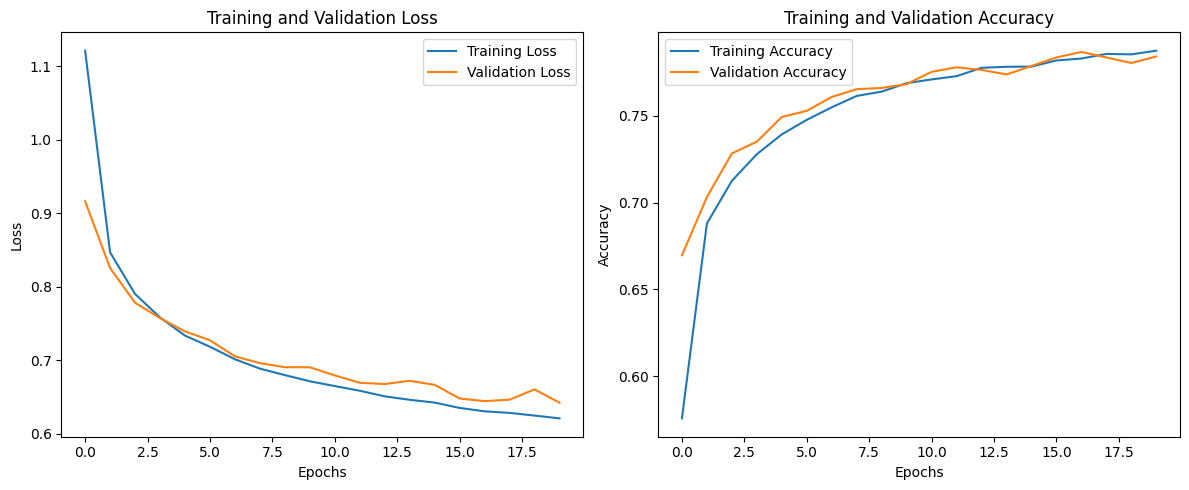

In [28]:
epochs = range(len(train_losses))

plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Classification Model

In [29]:
cl_model.eval()

all_true_labels = []
all_predicted_labels = []

for batch in val_dataloader:
    with torch.no_grad():
        past_times, future_times, past_values, future_values, past_mask, future_mask, label = batch
        label = label.to(device)
        
        logits = cl_model(past_times, past_values, future_times, past_mask)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)

        all_true_labels.extend(label.cpu().numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())

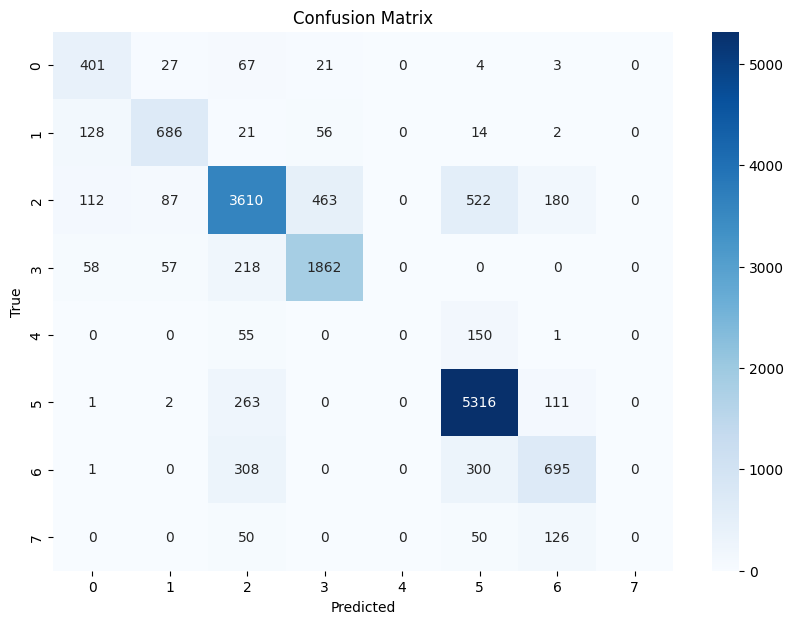

In [30]:
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()